Используя нейронную сеть Seq2Seq с механизмом Attention обучите переводчик с Русского на Английский язык

In [1]:
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1
UNK_token = 2  # токен для неизвестных слов
MAX_LENGTH = 700

In [2]:
 # Определение класса Lang для хранения словарей (английского и русского)
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Функции для преобразования предложения в тензоры
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes = indexes[:MAX_LENGTH]  # Обрезаем предложение до MAX_LENGTH
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)



In [4]:
import string
import re

# Функция для очистки текста
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s


In [5]:
# Функции для загрузки и обработки данных
def readLangs():
    lines = pd.read_csv('Rus-Eng-small.tsv', header=None, delimiter='\t')
    pairs = [[normalizeString(x[1]), normalizeString(x[3])] for x in lines.to_numpy()]  # выбор нужных столбцов и нормализация текста
    input_lang = Lang('rus')
    output_lang = Lang('eng')

    # добавляем каждое предложение в словари языка
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    return input_lang, output_lang, pairs



def tensorsFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [6]:
# Определение классов EncoderRNN и AttnDecoderRNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [7]:
# Функции для обучения модели
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # Отсоединяем входные данные от градиентов

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [8]:
# Функция для запуска обучения
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'Итерация: {iter} ({iter / n_iters * 100}%), loss_avg: {print_loss_avg}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    torch.save({
        'encoder_state_dict': encoder.state_dict(),
        'attn_decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
    }, 'trained_model.pth')


In [9]:
# Функция для визуализации прогресса обучения
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Функция для оценки модели на произвольном предложении
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence) # Конвертируем входное предложение в тензор
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden() # Инициализируем скрытое состояние энкодера

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Проход по входному предложению
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device) # Начальный вход декодера - токен SOS

        decoder_hidden = encoder_hidden # Скрытое состояние декодера инициализируется последним скрытым состоянием энкодера

        decoded_words = [] # храним декодированные слова
        decoder_attentions = torch.zeros(max_length, max_length) # храним внимание

        # Проходимся по декодеру
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1) # Берем слово с наибольшей вероятностью
            if topi.item() == EOS_token: # Если это токен EOS, то завершаем
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()]) # Добавляем декодированное слово в список

            decoder_input = topi.squeeze().detach() # Обновляем вход декодера

        return decoded_words, decoder_attentions[:di + 1]

# Функция для случайной оценки модели
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Функция для подсчета BLEU score
def BLEU(sent1,sent2):
    sent1_bleu = []
    sent2_bleu = []

    for w1 in sent2:
        sent2_bleu.append(w1.split())

    for i, w2 in enumerate(sent1):
        sent1_bleu.append([w2.split()])

    sf = SmoothingFunction()
    score = corpus_bleu(sent1_bleu,sent2_bleu,weights = (0,1,0,0),smoothing_function= sf.method4)
    return score

# Визуализация
def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze()  
    fig = plt.figure(figsize=(200,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    ax.set_aspect('equal')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=100)
    ax.set_yticklabels([''] + output_words, fontsize=150)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

    # plt.tight_layout()
    plt.show()






# Оценка и отображение внимания
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence) # Оцениваем и получаем внимание
    print('Ввод =', input_sentence)
    print('Вывод =', ' '.join(output_words)) # Выводим декодированное предложение
    showAttention(input_sentence, output_words, attentions) # Показываем внимание


In [10]:
# Чтение данных и запуск обучения
input_lang, output_lang, pairs = readLangs()
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

Итерация: 5000 (6.666666666666667%), loss_avg: 4.498401125186247
Итерация: 10000 (13.333333333333334%), loss_avg: 4.338563498065035
Итерация: 15000 (20.0%), loss_avg: 4.152286820955763
Итерация: 20000 (26.666666666666668%), loss_avg: 3.9689495396001715
Итерация: 25000 (33.33333333333333%), loss_avg: 3.844258234512269
Итерация: 30000 (40.0%), loss_avg: 3.714055793940384
Итерация: 35000 (46.666666666666664%), loss_avg: 3.660084959200614
Итерация: 40000 (53.333333333333336%), loss_avg: 3.5953310018243165
Итерация: 45000 (60.0%), loss_avg: 3.5753971885355567
Итерация: 50000 (66.66666666666666%), loss_avg: 3.468015166364525
Итерация: 55000 (73.33333333333333%), loss_avg: 3.4178162937753616
Итерация: 60000 (80.0%), loss_avg: 3.3764224113721824
Итерация: 65000 (86.66666666666667%), loss_avg: 3.3614987827405756
Итерация: 70000 (93.33333333333333%), loss_avg: 3.3317819100134263
Итерация: 75000 (100.0%), loss_avg: 3.270256182340867


Ввод = Один раз в жизни я делаю хорошее дело... И оно бесполезно.
Вывод = life last i last i life i in <EOS>


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\1791590718.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontsize=100)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\1791590718.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words, fontsize=150)


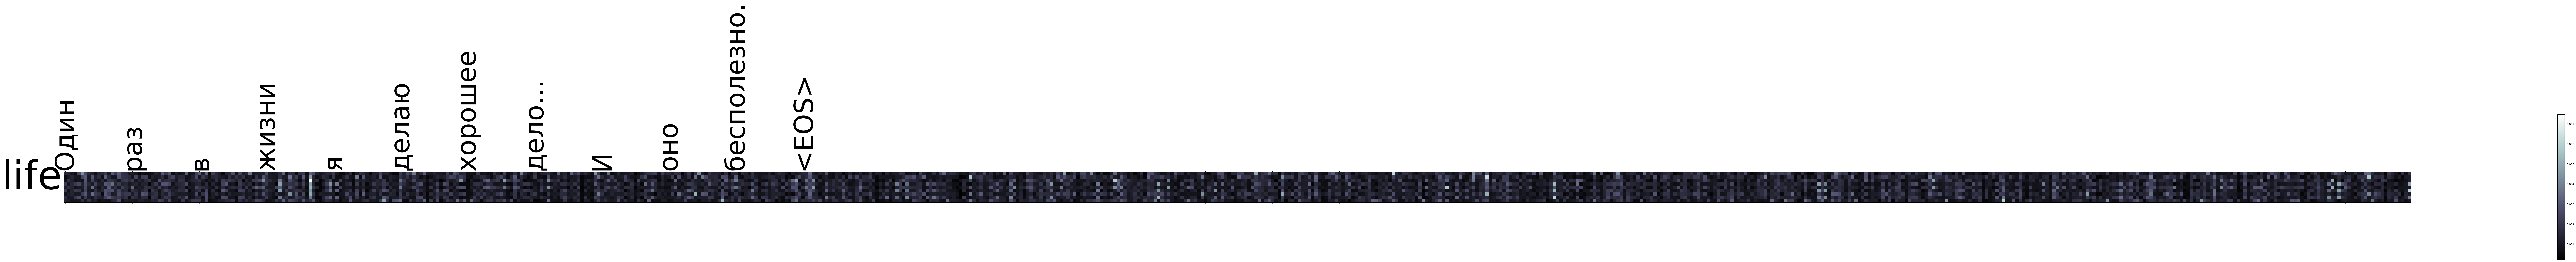

Ввод = Давайте что-нибудь попробуем!
Вывод = the your are <EOS>


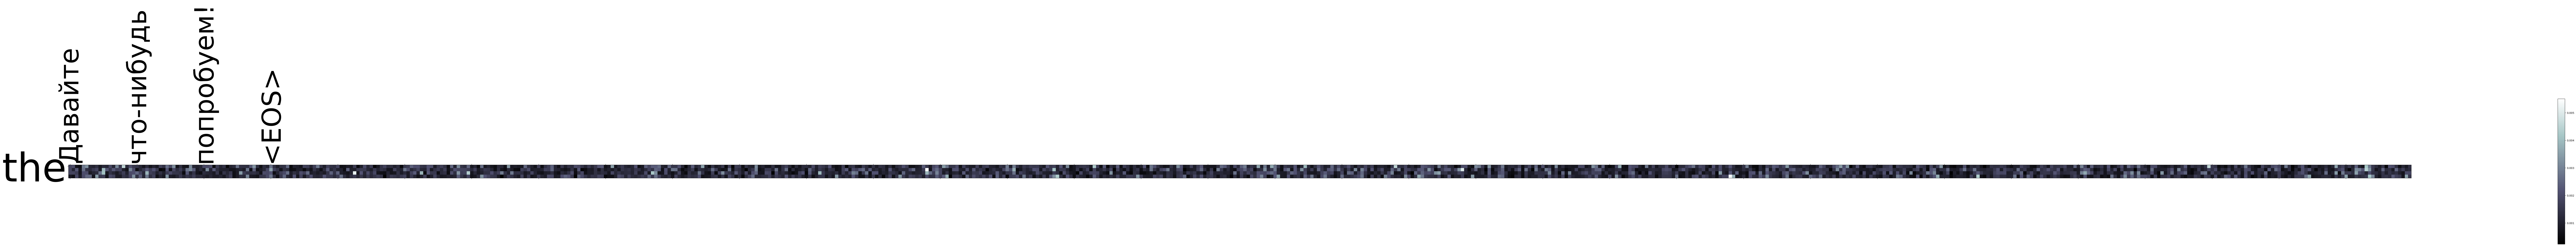

Ввод = Мне пора идти спать.
Вывод = it s time to to to <EOS>


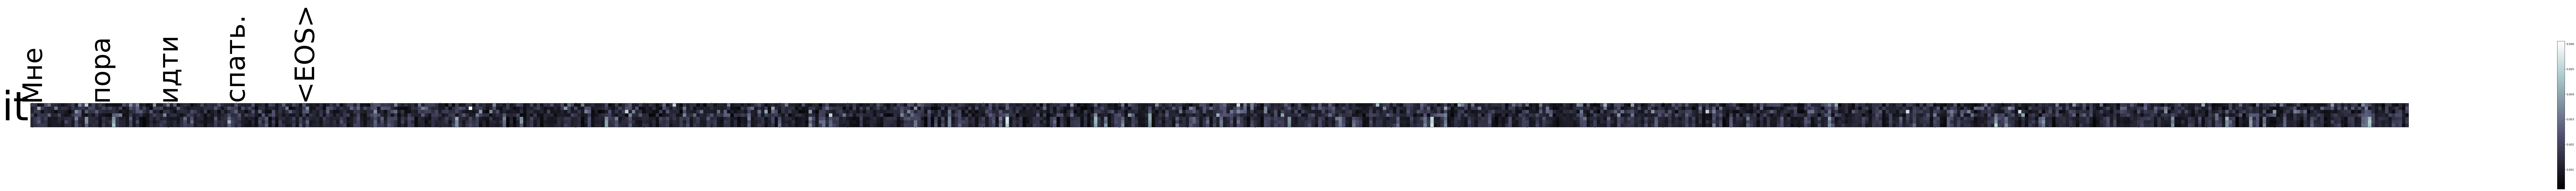

Ввод = Что ты делаешь?
Вывод = you are your . <EOS>


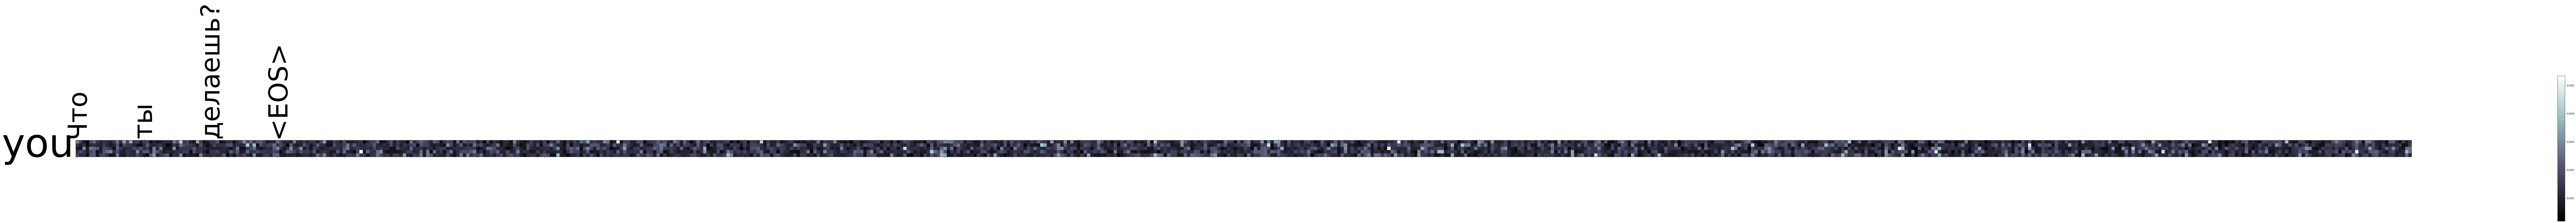

Ввод = Что это?
Вывод = the your are <EOS>


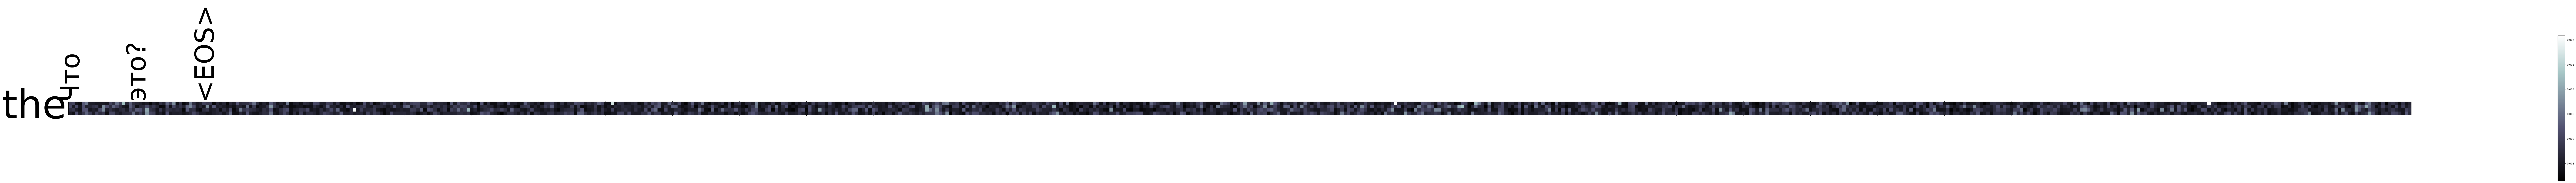

Ввод = У меня нет слов.
Вывод = i don t have for for <EOS>


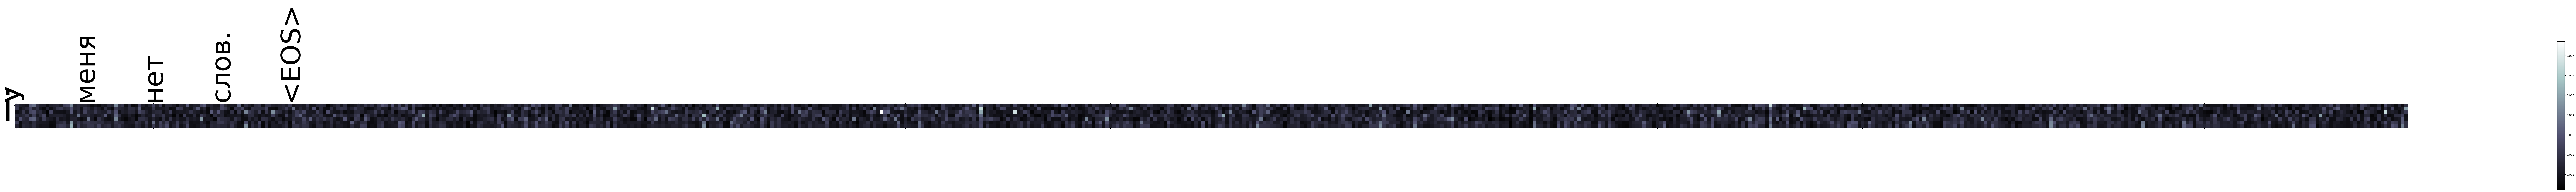

Ввод = Микрофон по какой-то причине до этого не работал.
Вывод = the it that it to it <EOS>


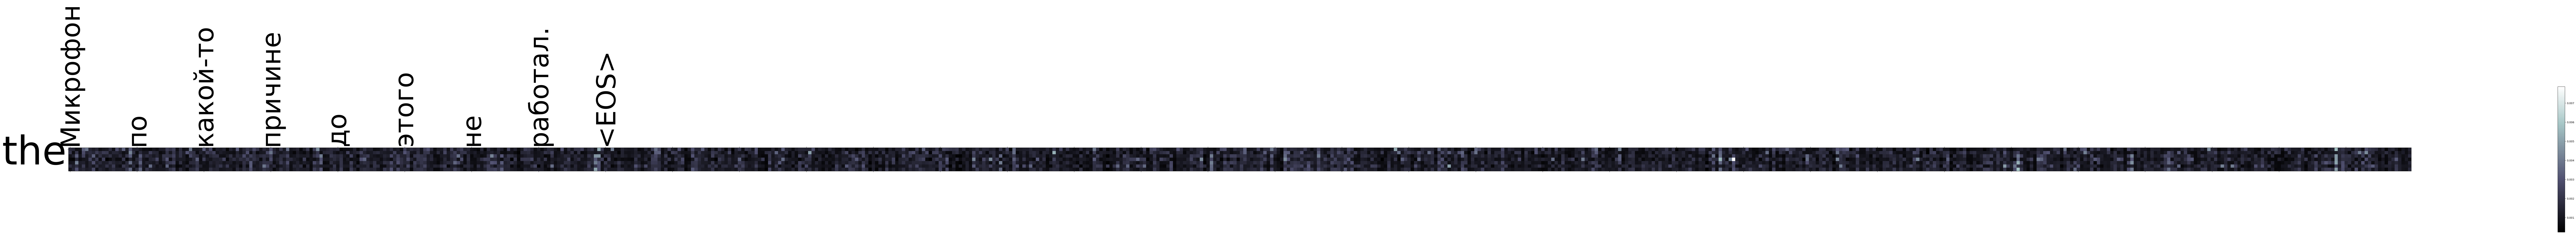

0


In [12]:
evaluateAndShowAttention("Один раз в жизни я делаю хорошее дело... И оно бесполезно.")
evaluateAndShowAttention("Давайте что-нибудь попробуем!")
evaluateAndShowAttention("Мне пора идти спать.")
evaluateAndShowAttention("Что ты делаешь?")
evaluateAndShowAttention("Что это?")
evaluateAndShowAttention("У меня нет слов.")
evaluateAndShowAttention("Микрофон по какой-то причине до этого не работал.")

# BLEU
print(BLEU(['У меня нет слов.'], ['I am at a loss for words.']))